In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../src/")
import importlib
import structures
importlib.reload(structures)
from structures import *
#import losses
#importlib.reload(losses)
#from losses import *
#import trainer
#importlib.reload(trainer)
#from trainer import *
#dtype = torch.float32
#dtype = torch.double
dtype = torch.float32
torch.set_default_dtype(dtype)
torch.autograd.set_detect_anomaly(True)
# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#import deepspeed
import random
sys.path.append("/mnt/home/yjo10/ceph/myutils")
import plt_utils as pu

torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()
# Cosine‑annealing with warmup
#from timm.scheduler import create_scheduler
from types import SimpleNamespace
from tqdm import tqdm


Using device: cuda


In [4]:
sys.path.append("../src/")
import importlib
import dataloader
importlib.reload(dataloader)
from dataloader import *
torch.cuda.empty_cache()
import gc
# Garbage collect
gc.collect()

29

In [13]:
batch_size=64
individual = False
_dataSB35, _labelsSB35, _minmaxSB35 = loadCAMELS(field="Mtot",box="SB35", normalization=False, individual=individual)
labelsSB35 = torch.tensor(_labelsSB35, dtype=dtype)

In [14]:
linear = False
dataSB35_norm = np.log10(_dataSB35)
dataSB35_norm_mean, dataSB35_norm_std = dataSB35_norm.mean(), dataSB35_norm.std()
dataSB35_norm = (dataSB35_norm -  dataSB35_norm_mean)/dataSB35_norm_std
dataSB35 = torch.tensor(dataSB35_norm,dtype=dtype)
_, val_setSB35 = split_expanded_dataset(dataSB35, labelsSB35, chunk_size=30, val_ratio=0.2,shuffle=True)
val_loaderSB35 = DataLoader(val_setSB35, batch_size=batch_size, shuffle=False)

### Plot

In [25]:
def get_predictions(model, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    predictions = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            predictions.append(outputs.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions = predictions*(minmax[:,1]-minmax[:,0]) + minmax[:,0]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6f}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]

    
def get_predictions2(model, model1, val_loader, minmax, max_plots=6, device='cuda'):
    model.eval()
    model1.eval()
    predictions = []
    predictions1 = []
    truths = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            outputs1 = model1(inputs)
            predictions.append(outputs.cpu())
            predictions1.append(outputs1.cpu())
            truths.append(targets.cpu())

    predictions = torch.cat(predictions, dim=0).numpy()  # [N, D]
    predictions1 = torch.cat(predictions1, dim=0).numpy()  # [N, D]
    predictions = np.c_[predictions,predictions1]
    truths = torch.cat(truths, dim=0).numpy()            # [N, D]
    predictions = predictions*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]
    #truths      = truths*(minmax[:2,1]-minmax[:2,0]) + minmax[:2,0]


    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")

    # Plot prediction vs truth for a few dimensions
    D = predictions.shape[1]
    plot_dims = min(D, max_plots)
    return [truths, predictions, plot_dims]


def plot_per_simulation(data, max_plots=6, chunk_size=15, num_samples=None, sample_indices=None, title=""):
    truths, predictions, plot_dims = data

    # Compute mean squared error per output dimension
    mse_per_dim = ((predictions - truths) ** 2).mean(axis=0)
    mse_total = mse_per_dim.mean()
    print(f"Validation MSE (average over {predictions.shape[1]} targets): {mse_total:.6e}")
    target_name = ["$\Omega_m$", "$\sigma_8$"]

    fig, axs = plt.subplots(1, plot_dims, figsize=(5 * plot_dims, 4))
    axs = np.array(axs).reshape(-1)

    for i in range(plot_dims):
        array_chunk = predictions.reshape(-1,chunk_size,plot_dims)
        mean = array_chunk.mean(axis=1)
        std  = array_chunk.std(axis=1)
        true = truths[::chunk_size,:]
        #print(mean)

        if sample_indices is not None:
            x    = true[sample_indices, i]
            y    = mean[sample_indices,i]
            yerr = std[sample_indices,i]
            c    = range(len(sample_indices))
        elif num_samples is not None:
            x    = true[:num_samples, i]
            y    = mean[:num_samples,i]
            yerr = std[:num_samples,i]
        else:
            x    = true[:,i]
            y    = mean[:,i]
            yerr = std[:,i]
        
        bias_of_each = np.mean(truths[:, i] - predictions[:, i])
        bias_of_mean =  np.mean(x - y)
        std_of_each = np.std(truths[:, i] - predictions[:, i])
        mean_std = np.mean(yerr)
        textstr = f'bias_of_each={bias_of_each:.3e}\nstd_of_each={std_of_each:.3e}\nbias_of_mean={bias_of_mean:.3e}\nmean_std={mean_std:.3e}'

        #axs[i].scatter(truths[:, i], predictions[:, i], alpha=0.6, edgecolors='k')
        axs[i].errorbar(x=x, y=y, yerr=yerr,
                        fmt='none',
                        markersize=2,        # size of the markers
                        capsize=2,           # length of the error bar caps
                        elinewidth=1.,      # width of the error bar lines
                        markeredgewidth=.5,   # edge width of the marker
                        markerfacecolor='none',
                        markeredgecolor='none',
                        ecolor='tab:orange')

        # overplot your dots with individual colors
        if sample_indices is not None:
            axs[i].scatter(x, y,
                c=c,
                cmap='viridis',
                s=16,           # marker size
                edgecolor='none',
                zorder=10)  # optional edge
        else:
            axs[i].scatter(x, y,
                s=4,           # marker size
                c="k",
                edgecolor='none',
                zorder=10)  # optional 
        axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                    [truths[:, i].min(), truths[:, i].max()],
                    'r--', label='Ideal',zorder=11)
                    # Text to show

        # Place text in bottom right corner
        axs[i].text(
            0.95, 0.05, textstr,
            transform=axs[i].transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
        )
        axs[i].set_title(f"Target {target_name[i]} | MSE: {mse_per_dim[i]:.4e}")
        axs[i].set_xlabel("Truth")
        axs[i].set_ylabel("Prediction")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)

    return 


### trained separately

In [26]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *

output_dim = labelsSB35.shape[1]

model = ConventionalCNN(input_shape=(512,512), output_shape=output_dim, H=16, output_positive=True)
model.to(device)

model.load_state_dict(torch.load("../data/models/SB35_conv_no_linear_Mtot_proposal_best.pt"))

#data35 = get_predictions(model, val_loaderSB35, _minmaxSB35, device=device)
data35 = get_predictions(model, val_loaderSB35, _minmaxSB35, device=device)

Validation MSE (average over 35 targets): 43156.686876


In [20]:
from sklearn.metrics import r2_score, mean_squared_error

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


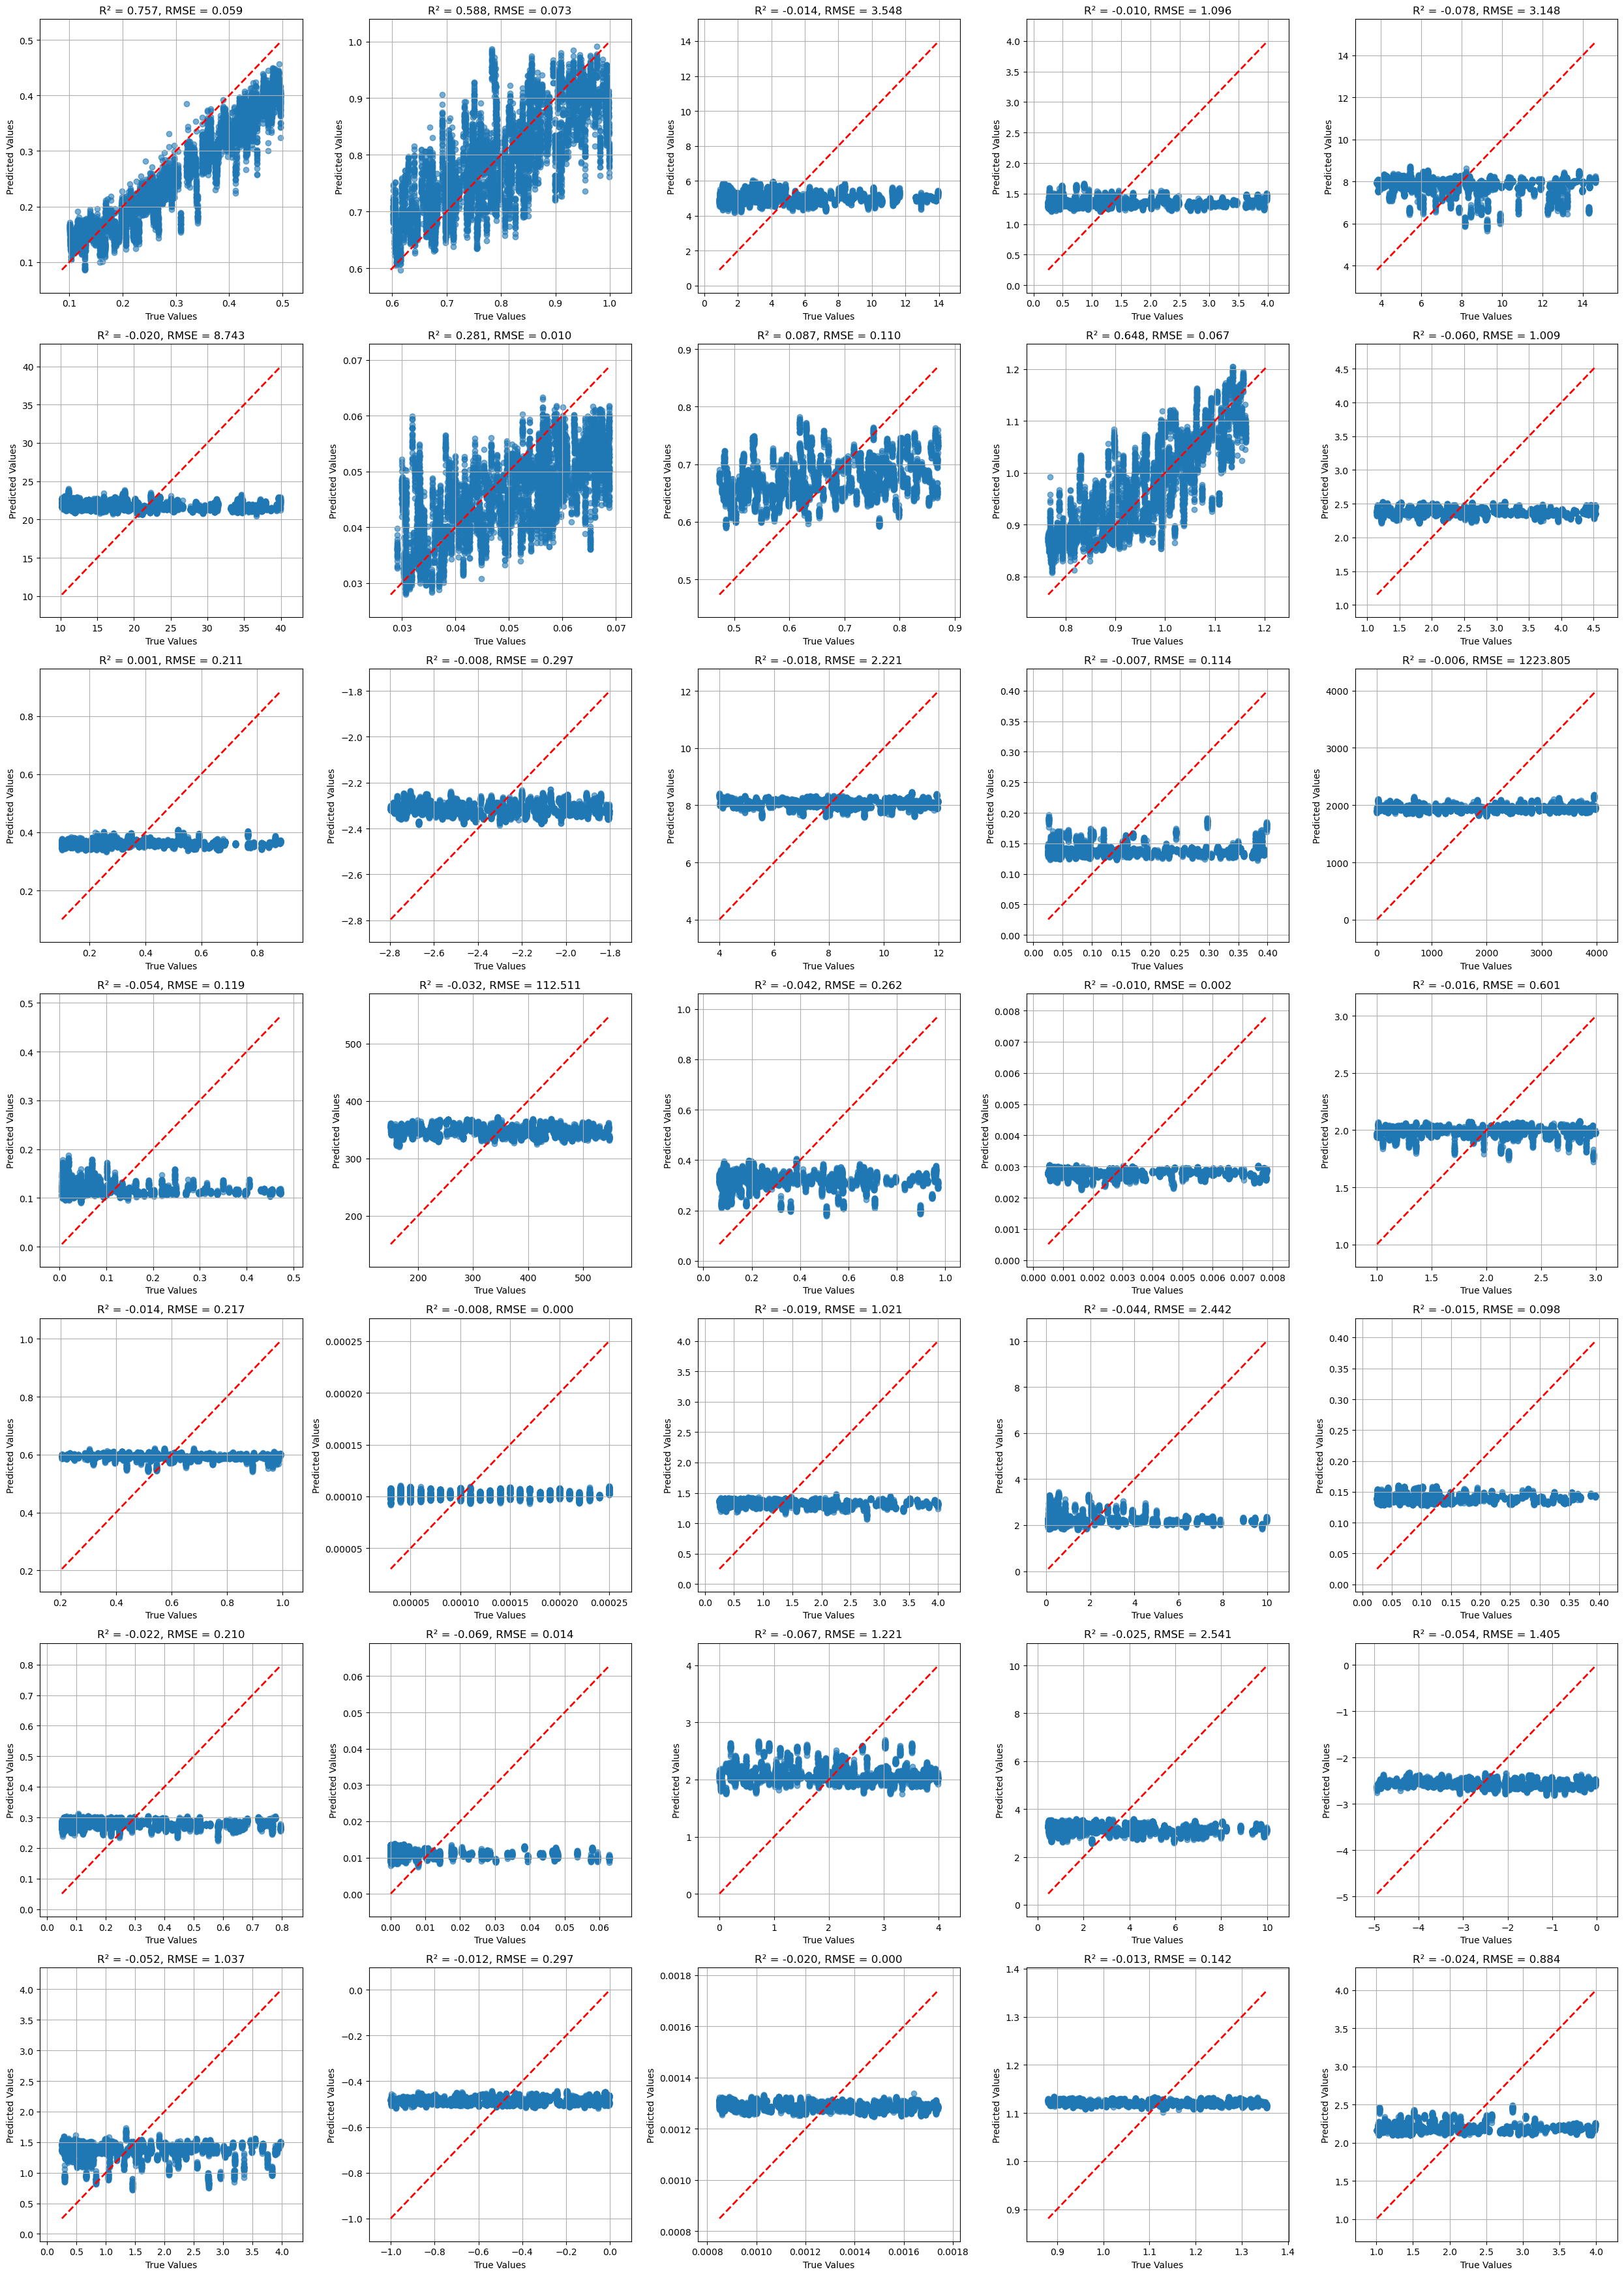

In [27]:
n_cols = int(np.floor(np.sqrt(output_dim)))
n_rows = int(np.ceil(output_dim / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = np.atleast_1d(axes).reshape(n_rows, n_cols)
for i in range(output_dim):
    ax = axes.flat[i]
    predictions = data35[1][:, i]
    true_values = data35[0][:, i]
    ax.scatter(true_values, predictions, alpha=0.6)
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    min_val = min(true_values.min(), predictions.min())
    max_val = max(true_values.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'R\u00b2 = {r2:.3f}, RMSE = {rmse:.3f}')
    ax.grid(True)
    span = max_val - min_val
    ax.set_xlim(min_val - 0.1 * span, max_val + 0.1 * span)
    ax.set_ylim(min_val - 0.1 * span, max_val + 0.1 * span)
for j in range(output_dim, n_rows * n_cols):
    fig.delaxes(axes.flat[j])
fig.tight_layout()
#fig.savefig('../../../plots/results_plot.png')
plt.show()

Validation MSE (average over 2 targets): 2.704867e-03
Validation MSE (average over 2 targets): 2.704867e-03
Validation MSE (average over 2 targets): 2.757888e-03
Validation MSE (average over 2 targets): 2.757888e-03
Validation MSE (average over 2 targets): 2.900854e-03
Validation MSE (average over 2 targets): 2.900854e-03
Validation MSE (average over 2 targets): 2.878171e-03
Validation MSE (average over 2 targets): 2.878171e-03
Validation MSE (average over 2 targets): 2.886823e-03
Validation MSE (average over 2 targets): 2.886823e-03
Validation MSE (average over 2 targets): 2.977629e-03
Validation MSE (average over 2 targets): 2.977629e-03
Validation MSE (average over 2 targets): 2.940117e-03
Validation MSE (average over 2 targets): 2.940117e-03
Validation MSE (average over 2 targets): 3.032293e-03
Validation MSE (average over 2 targets): 3.032293e-03
Validation MSE (average over 2 targets): 2.958813e-03
Validation MSE (average over 2 targets): 2.958813e-03


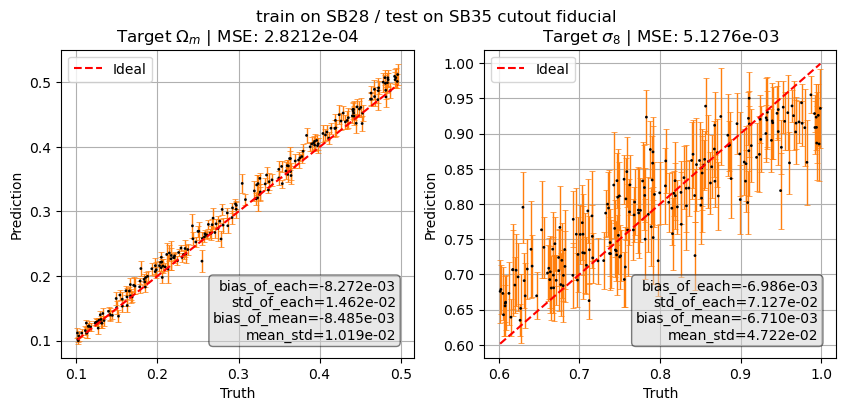

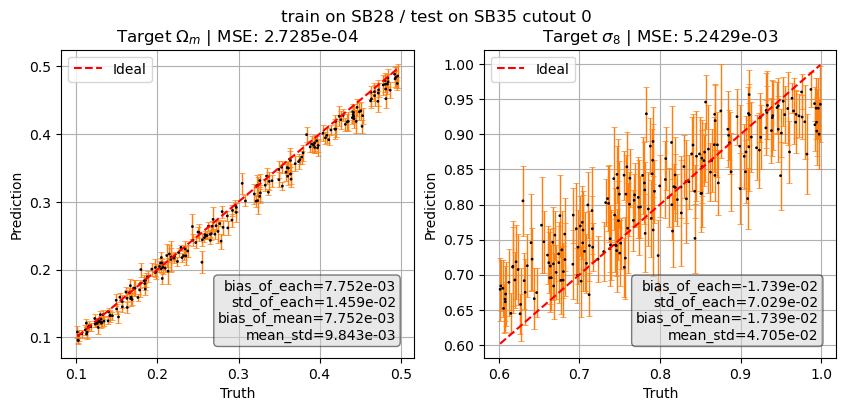

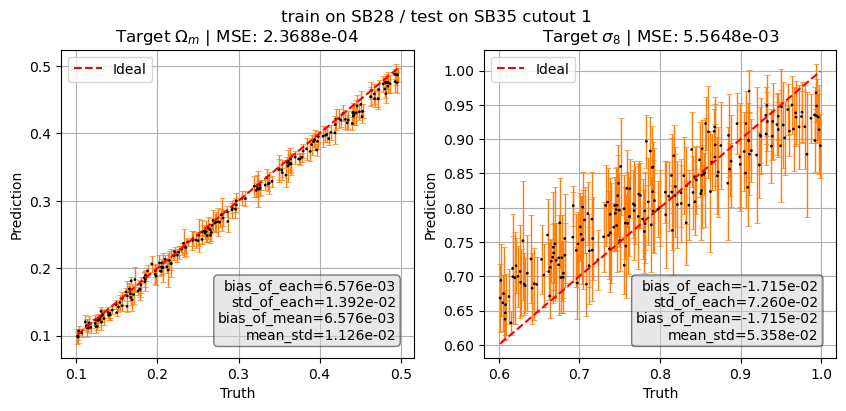

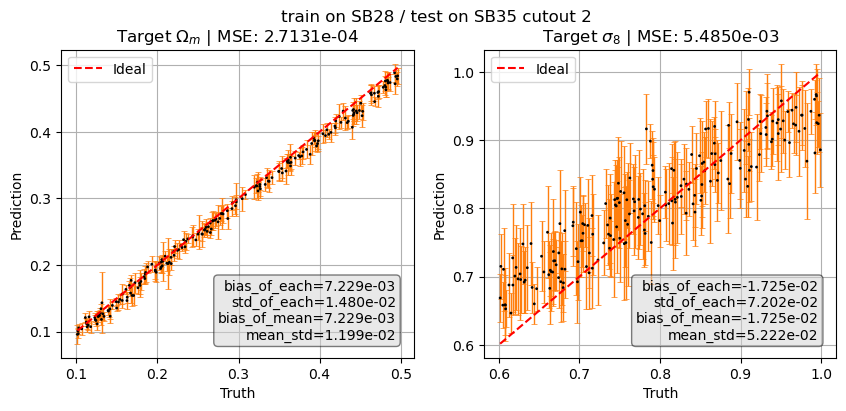

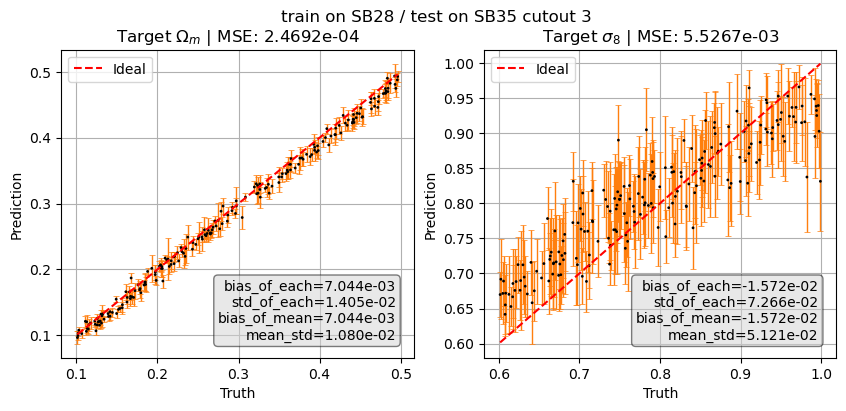

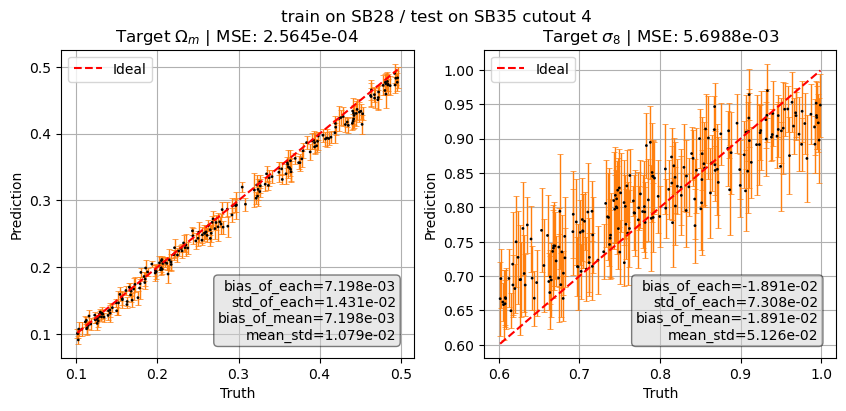

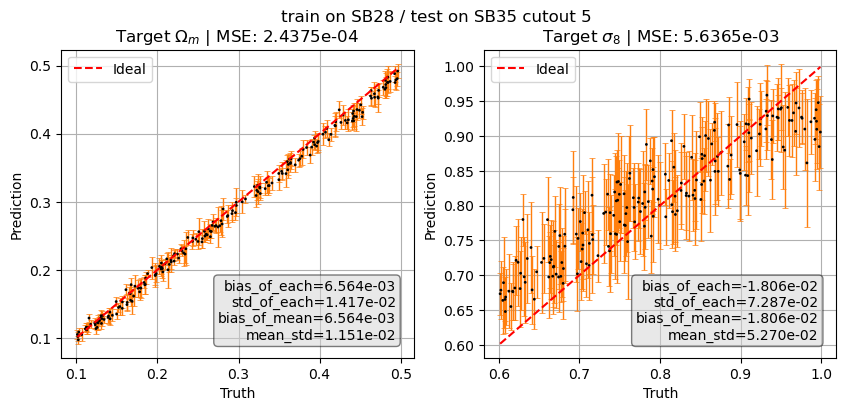

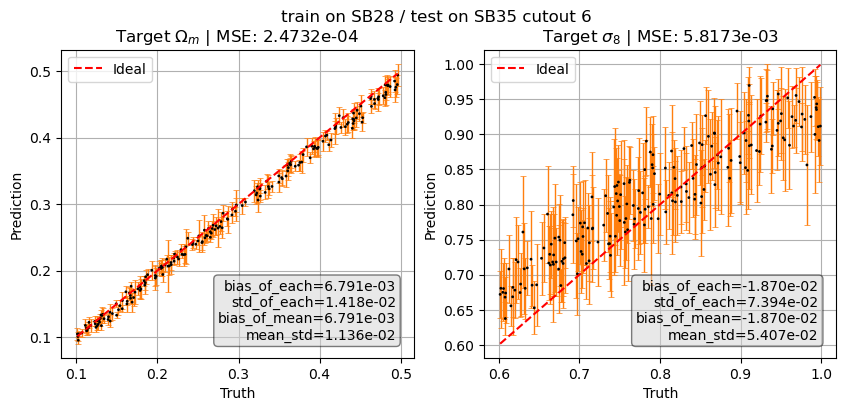

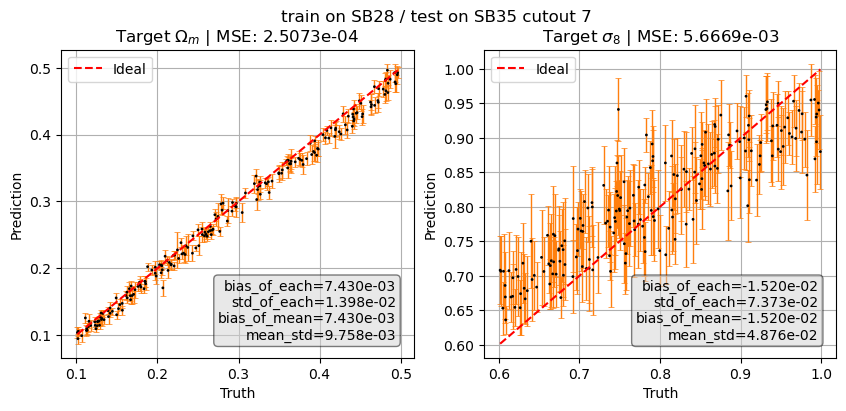

In [37]:
data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout2, _minmaxSB28, device=device)
plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=200, title=f"train on SB28 / test on SB35 cutout fiducial")
for i, cutout in enumerate(cutouts):
  data35_cutout = get_predictions2(model, model1, cutout, _minmaxSB28, device=device)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=None, title=f"train on SB28 / test on SB35 cutout {i}")

In [20]:
cutouts = []

dataSB35_norm = np.log10(_dataSB35)
dataSB35_norm_mean, dataSB35_norm_std = dataSB35_norm.mean(), dataSB35_norm.std()

arr = np.arange(_dataSB35_cutout.shape[0])
step = 10
length = 5

# compute all start‐indices
starts = np.arange(0, len(arr)-length+1, step)   # [  0,  30,  60, …]
# build a 2D index array of shape (n_chunks, length)
idx = starts[:,None] + np.arange(length)   
idx1 = idx.flatten()

# compute all start‐indices
starts = np.arange(5, len(arr)+1, step)   # [  0,  30,  60, …]
# build a 2D index array of shape (n_chunks, length)
idx = starts[:,None] + np.arange(length)   
idx2 = idx.flatten()



cutouts.append(_dataSB35[idx1,:256,:256])
cutouts.append(_dataSB35[idx1,:256,256:])
cutouts.append(_dataSB35[idx1,256:,:256])
cutouts.append(_dataSB35[idx1,256:,256:])
cutouts.append(_dataSB35[idx2,:256,:256])
cutouts.append(_dataSB35[idx2,:256,256:])
cutouts.append(_dataSB35[idx2,256:,:256])
cutouts.append(_dataSB35[idx2,256:,256:])

for i, cutout in enumerate(cutouts):
  cutout = np.log10(cutout)
  cutout = (cutout -  dataSB35_norm_mean)/dataSB35_norm_std

  cutout = torch.tensor(cutout,dtype=dtype)
  #_, cutout = split_expanded_dataset(cutout, labelsSB35, chunk_size=15, val_ratio=0.999,shuffle=True)
  cutouts[i] = DataLoader(cutout, batch_size=batch_size, shuffle=False)

In [22]:
import validator 
importlib.reload(validator)
from validator import *
import structures
importlib.reload(structures)
from structures import *
output_dim = 1#labelsSB28.shape[1]


model2 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model2.to(device)
model3 = ConventionalCNN(input_shape=(256,256), output_shape=output_dim, H=16, output_positive=True)
model3.to(device)


model2.load_state_dict(torch.load("../data/models/SB35_cutout2_conv_no_linear_om_best.pt"))
model3.load_state_dict(torch.load("../data/models/SB35_cutout2_conv_no_linear_sig_best.pt"))


#data28        = get_predictions2(model, model1, val_loaderSB28, _minmaxSB28, device=device)
#data35_cutout = get_predictions2(model, model1, val_loaderSB35_cutout2, _minmaxSB28, device=device)

<All keys matched successfully>

Validation MSE (average over 2 targets): 2.199604e-03
Validation MSE (average over 2 targets): 2.199604e-03
Validation MSE (average over 2 targets): 2.008300e-03
Validation MSE (average over 2 targets): 2.008300e-03
Validation MSE (average over 2 targets): 2.321367e-03
Validation MSE (average over 2 targets): 2.321367e-03
Validation MSE (average over 2 targets): 2.307647e-03
Validation MSE (average over 2 targets): 2.307647e-03
Validation MSE (average over 2 targets): 2.348438e-03
Validation MSE (average over 2 targets): 2.348438e-03
Validation MSE (average over 2 targets): 2.332593e-03
Validation MSE (average over 2 targets): 2.332593e-03
Validation MSE (average over 2 targets): 2.332563e-03
Validation MSE (average over 2 targets): 2.332563e-03
Validation MSE (average over 2 targets): 2.329588e-03
Validation MSE (average over 2 targets): 2.329588e-03
Validation MSE (average over 2 targets): 2.352324e-03
Validation MSE (average over 2 targets): 2.352324e-03


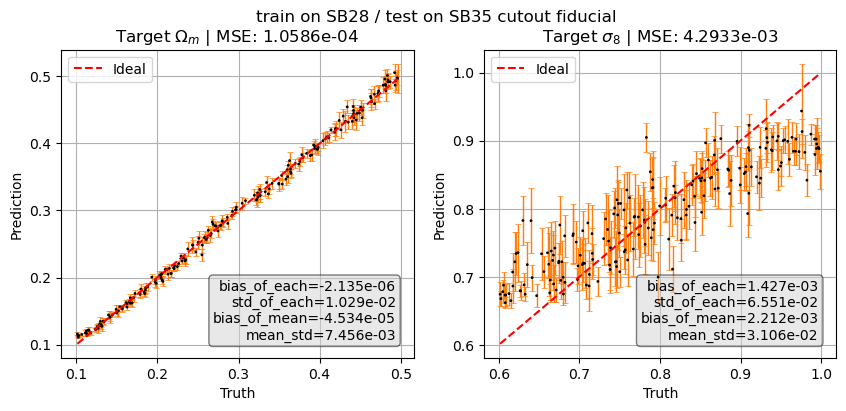

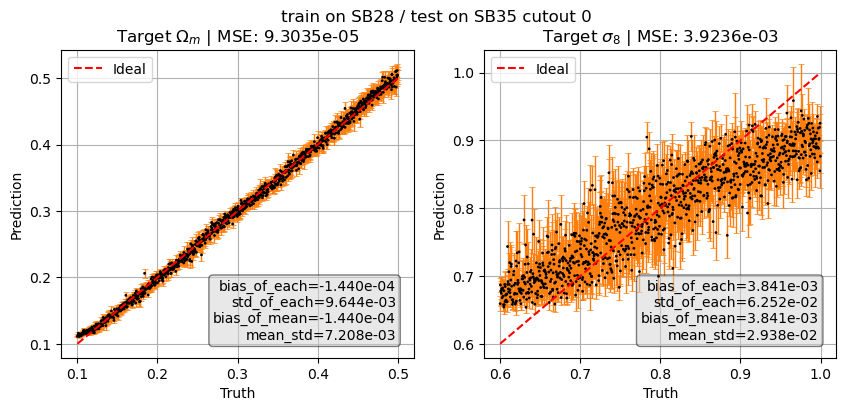

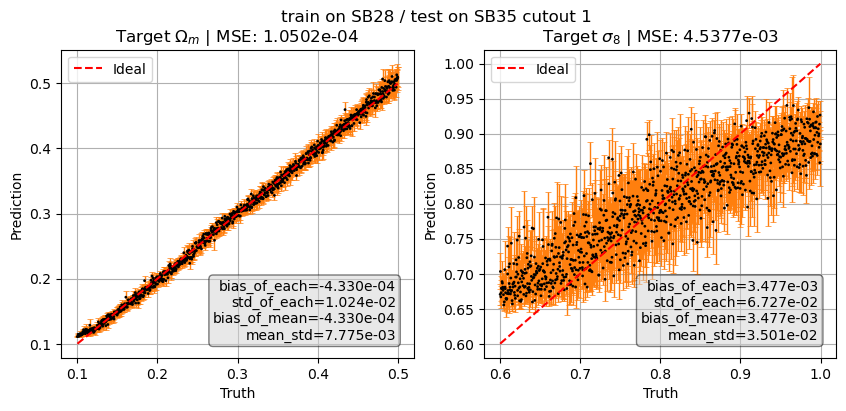

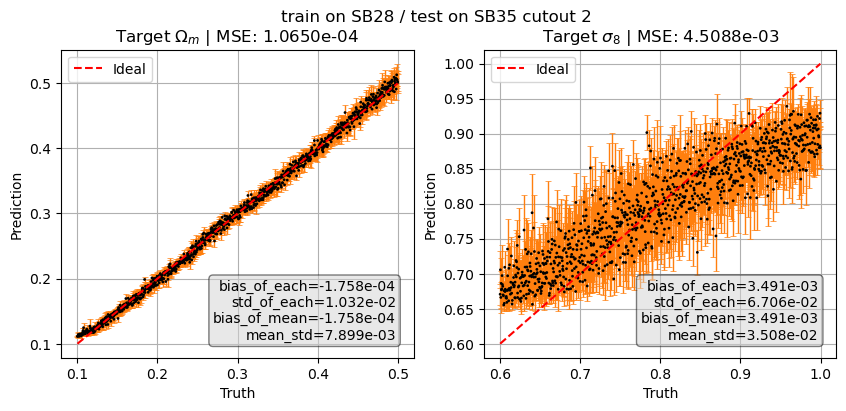

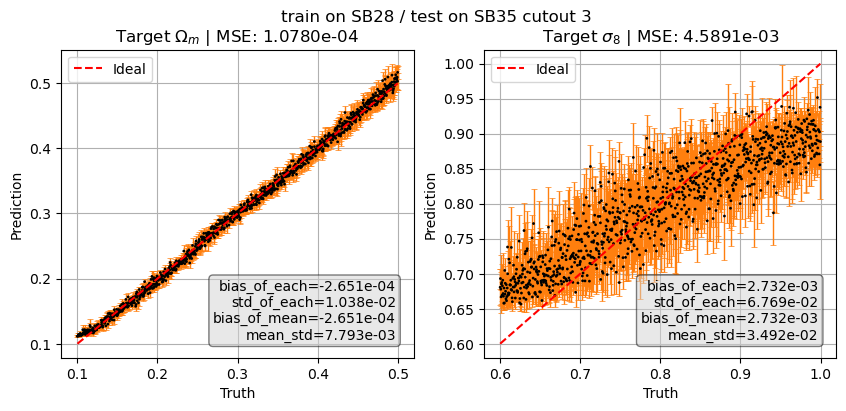

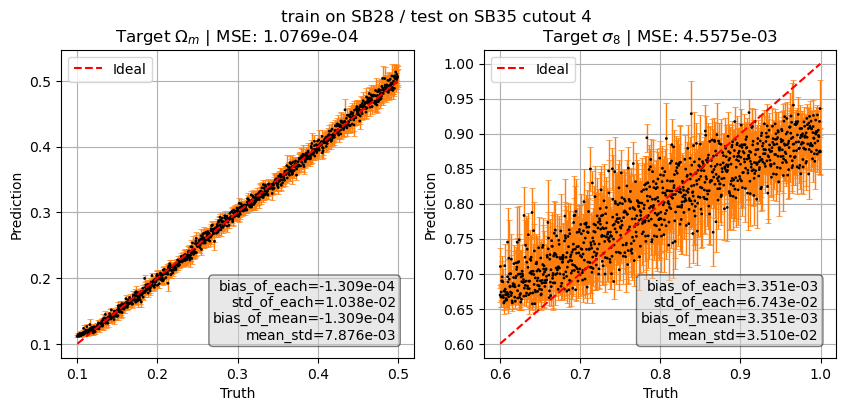

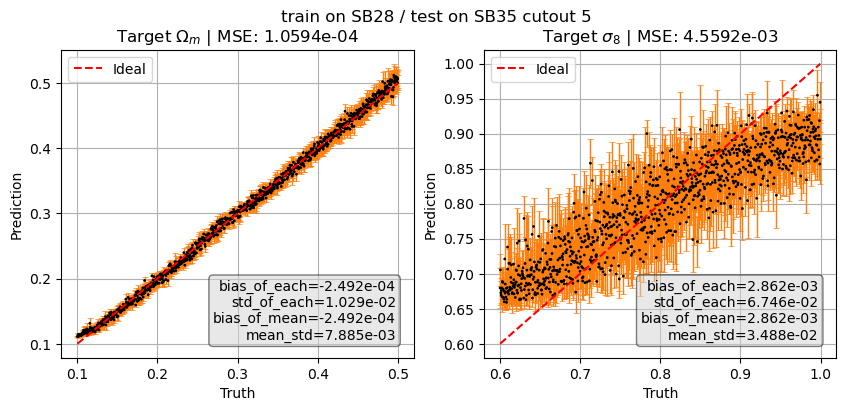

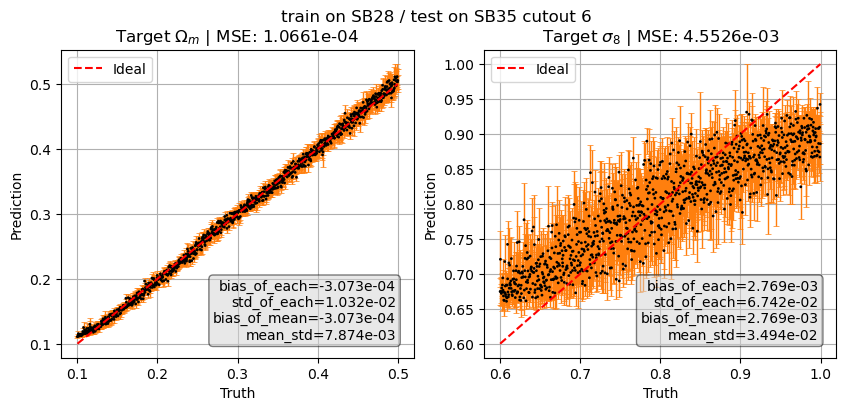

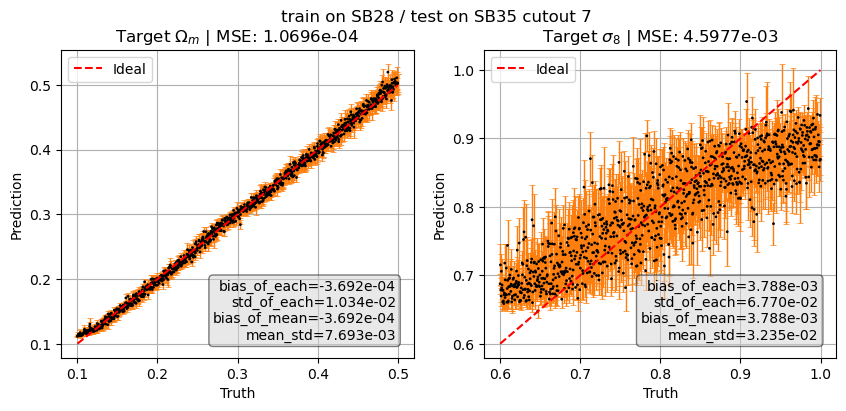

In [23]:
data35_cutout = get_predictions2(model2, model3, val_loaderSB35_cutout2, _minmaxSB35, device=device)
plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=200, title=f"train on SB28 / test on SB35 cutout fiducial")
for i, cutout in enumerate(cutouts):
  data35_cutout = get_predictions2(model2, model3, cutout, _minmaxSB35, device=device)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=None, title=f"train on SB28 / test on SB35 cutout {i}")

Validation MSE (average over 2 targets): 2.370944e-03
Validation MSE (average over 2 targets): 2.370944e-03
Validation MSE (average over 2 targets): 2.129023e-03
Validation MSE (average over 2 targets): 2.129023e-03
Validation MSE (average over 2 targets): 2.563427e-03
Validation MSE (average over 2 targets): 2.563427e-03
Validation MSE (average over 2 targets): 2.569395e-03
Validation MSE (average over 2 targets): 2.569395e-03
Validation MSE (average over 2 targets): 2.627382e-03
Validation MSE (average over 2 targets): 2.627382e-03
Validation MSE (average over 2 targets): 2.592589e-03
Validation MSE (average over 2 targets): 2.592589e-03
Validation MSE (average over 2 targets): 2.581549e-03
Validation MSE (average over 2 targets): 2.581549e-03
Validation MSE (average over 2 targets): 2.604656e-03
Validation MSE (average over 2 targets): 2.604656e-03
Validation MSE (average over 2 targets): 2.641448e-03
Validation MSE (average over 2 targets): 2.641448e-03


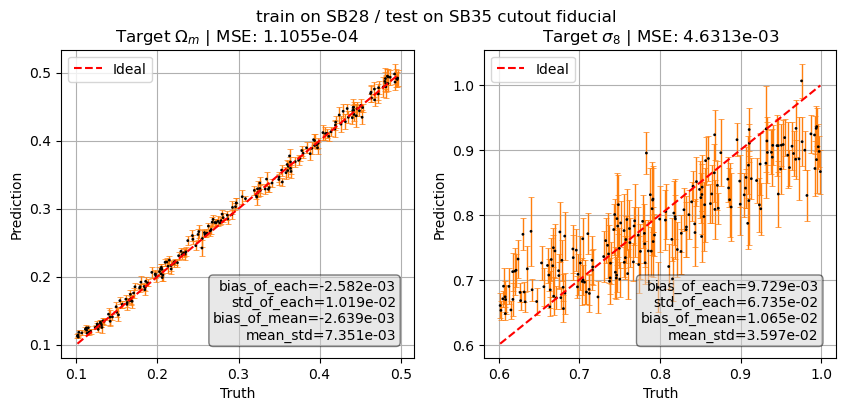

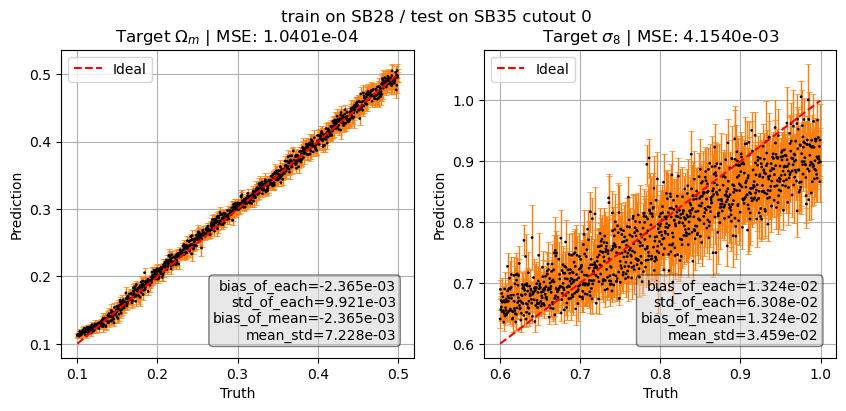

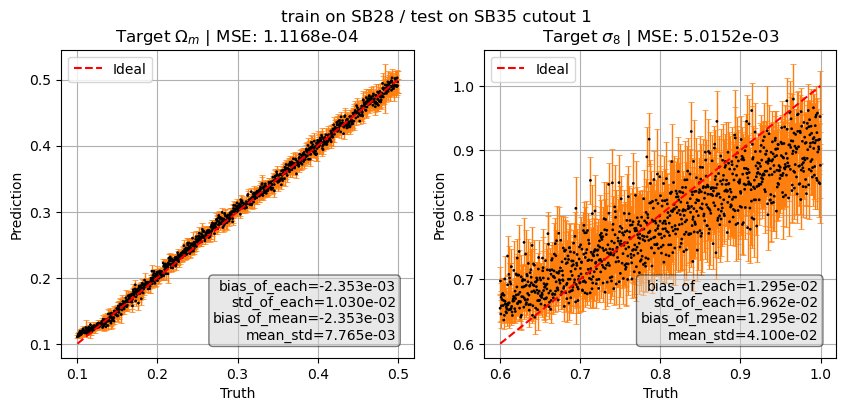

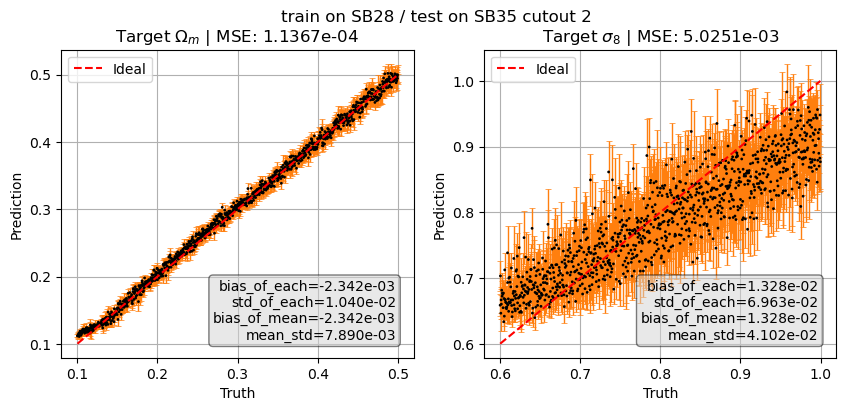

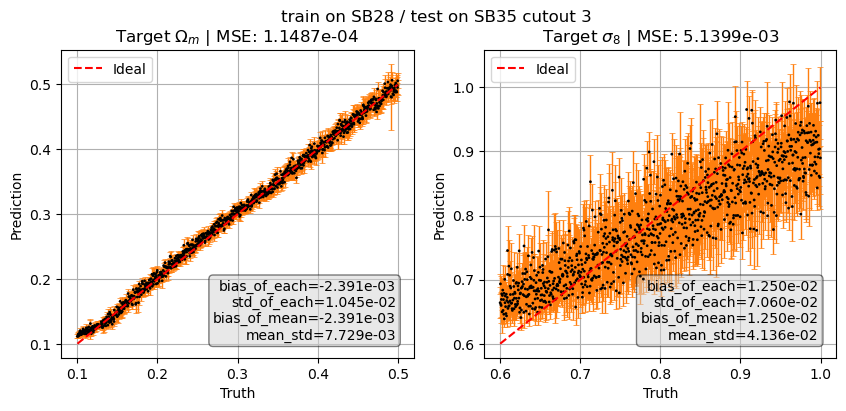

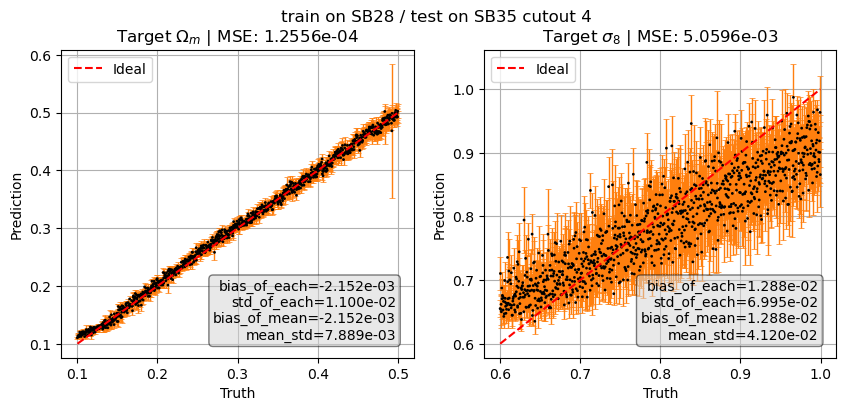

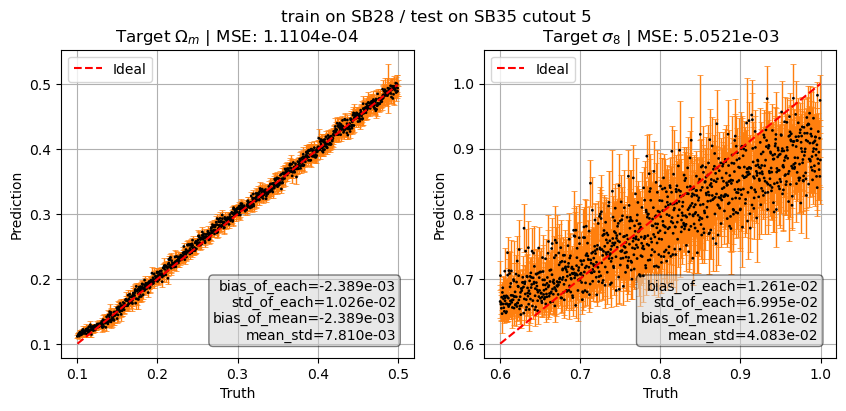

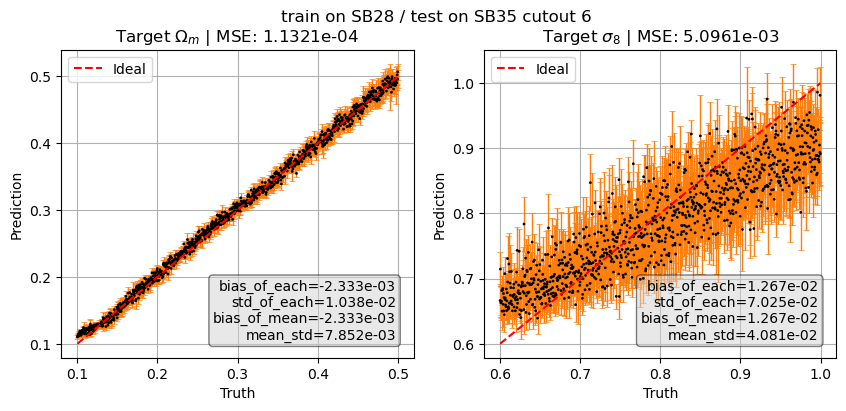

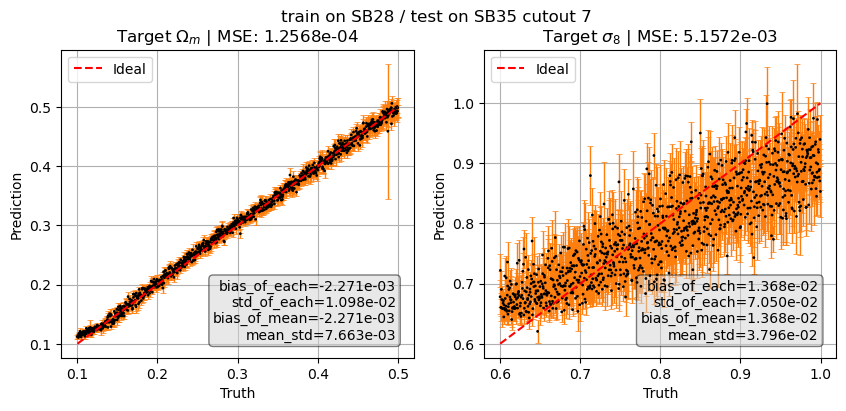

In [ ]:
data35_cutout = get_predictions2(model2, model3, val_loaderSB35_cutout2, _minmaxSB35, device=device)
plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=200, title=f"train on SB28 / test on SB35 cutout fiducial")
for i, cutout in enumerate(cutouts):
  data35_cutout = get_predictions2(model2, model3, cutout, _minmaxSB35, device=device)
  plot_per_simulation(data35_cutout, max_plots=6, chunk_size=15,num_samples=None, title=f"train on SB28 / test on SB35 cutout {i}")